# POLI/USP Trabalho de Conclusão de Curso

## Fine Tuning - Modelo Mistral
Autor: Gabriel Benvegmi
Esse notebook faz o processo de fine-tuning para o modelo Mistral. Ele foi executado no Google Colab.



In [ ]:
!pip install -q evaluate
!pip install -q rouge_score
!pip install -q loralib datasets
!pip install -q transformers autoawq
!pip install -q einops accelerate bitsandbytes sentencepiece -U
!pip install -q sentence_transformers
!pip install -q google-cloud-secret-manager gspread
!pip install -q google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install -q git+https://github.com/huggingface/peft.git

# ATENÇÃO
Reiniciar kernel depois da instalação dos elementos acima para que o modelo quantizado seja capaz de localizar as bibliotecas bitsandbytes e accelerate corretamente.

In [ ]:
import json
import os

import gspread
import pandas as pd
import transformers
import torch
from datasets import load_dataset, Dataset
from evaluate import load
from google.colab import drive, userdata
from google.oauth2 import service_account
from huggingface_hub import login
from peft import get_peft_model, prepare_model_for_int8_training, LoraConfig, PeftModel, TaskType
from sklearn.model_selection import train_test_split
from transformers import BitsAndBytesConfig, DataCollatorWithPadding, MistralForCausalLM, MistralModel, AutoModelForCausalLM, AutoTokenizer


login(userdata.get('huggingface_token'))

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
metric = load("rouge")

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Carregando dados para fine-tuning

In [ ]:
save_path = "/content/drive/MyDrive/Estudos/Poli/TCC/notebooks/"

In [ ]:
docs_df = pd.read_csv(save_path + "2_summaries_dataset.csv", index_col=0, usecols=[1, 2, 3])

In [ ]:
df_train, df_val = train_test_split(docs_df, shuffle=True, random_state=42, test_size=0.15)

In [ ]:
print(df_train.shape)
print(df_val.shape)

(60, 2)
(11, 2)


In [ ]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
train_dataset

Dataset({
    features: ['source_text', 'target_summary', 'published_title'],
    num_rows: 60
})

## Carregando modelo

In [ ]:
# https://www.kaggle.com/code/archanghosh/quantized-mistral-7b-approach

"""
A PeFT config nos habilita a criar um LoRA Adapter para o modelo quantizado que nos permitirá
treiná-lo. A BnB Config carrega o modelo em quantização 4-Bit, reduzindo nossa exigência de hardware
de 60GB para apenas 13GB
"""

peft_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    target_modules=[
        "q_proj",
        "v_proj"
    ],
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model_str = "mistralai/Mistral-7B-v0.1"
MAX_LENGTH = 1024

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_str, cache_dir=save_path + "cache")

# Adição do Pad token
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Carregando o modelo
model_quantized = AutoModelForCausalLM.from_pretrained(model_str, quantization_config=bnb_config, cache_dir=save_path + "cache")

# Configurando Pretraining_tp para 1 garante que estejamos usando as camadas lineares com a máxima computação possível
model_quantized.config.pretraining_tp = 1

# Garantindo que o modelo esteja configurado com o pad token ID correto
model_quantized.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Configurando o LoRA Adapter
model_main = get_peft_model(model_quantized, peft_config)

In [ ]:
model_main.quantization_method

<QuantizationMethod.BITS_AND_BYTES: 'bitsandbytes'>

In [ ]:
model_main.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(in_features=4096, out_features=1024, bia

## Preparando para treinamento

In [ ]:
def generate_prompt(input, output=None):
  prompt = f"""# CONTEXTO #
Extrair as informações principais de documentos do ecossistema financeiro.

# OBJETIVO #
Sumarize adequadamente o documento presente na ENTRADA. Extraia até três passagens principais do texto original, evitando ao máximo paráfrases, se atendo ao conteúdo literal.

# ESTILO #
Siga o estilo direto e impessoal dos documentos da ENTRADA. Evite enumerações ou a numeração das sentenças de saída, apenas concatene as sentenças em um formato comum de texto contínuo em sua ordem original.

# TOM #
Técnico.

# ENTRADA #
{input}

# RESPOSTA #
Sumário: """
  if output is not None:
     prompt += output

  return prompt

In [ ]:
proc_train_data = train_dataset.shuffle().map(
    lambda data_point: tokenizer(
        generate_prompt(data_point['source_text'], data_point['target_summary']),
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
    )
)

proc_val_data = val_dataset.shuffle().map(
    lambda data_point: tokenizer(
        generate_prompt(data_point['source_text'], data_point['target_summary']),
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
    )
)

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

In [ ]:
from transformers import Adafactor, get_cosine_schedule_with_warmup

learning_rate = 1e-3

batch_size = 2
epochs = 200
total_steps = round(len(proc_train_data) / batch_size) * epochs
warmup_steps = int(0.15 * total_steps)
save_steps = total_steps // 5
beta1 = 0.9

print(
    "batch_size  ", batch_size, "\n"
    "epochs      ", epochs, "\n"
    "total_steps ", total_steps, "\n"
    "warmup_steps ", warmup_steps, "\n"
    "save_steps ", save_steps, "\n"
    "beta1       ", beta1
)

optimizer = Adafactor(
    model_main.parameters(),
    lr=learning_rate,
    beta1=beta1,
    weight_decay=0,  # Configura weight decay como 0 pois o dynamic weight decay é aplicado separadamente
    scale_parameter=True,
    relative_step=False
)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
    )

batch_size   2 
epochs       200 
total_steps  6000 
warmup_steps  900 
save_steps  1200 
beta1        0.9


In [ ]:
run_name = "b3-summ-Mistral-7B-v0.1"
output_dir = "./" + run_name

training_args = transformers.TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_steps=save_steps,
    save_total_limit=9,
    evaluation_strategy="steps",
    eval_steps=save_steps,
    logging_steps=100,
    load_best_model_at_end=True,
    weight_decay=0.0,
    fp16=True,
)

In [ ]:
trainer = transformers.Trainer(
    model=model_main,
    args=training_args,
    train_dataset=proc_train_data,
    eval_dataset=proc_val_data,
    tokenizer=tokenizer,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

## Treinando

In [ ]:
trainer.train(resume_from_checkpoint=False)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
1200,0.077700,1.368863
2400,0.010400,1.611715
3600,0.006700,1.701985
4800,0.006300,1.731950
6000,0.005900,1.754258


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public

TrainOutput(global_step=6000, training_loss=0.056012194633483885, metrics={'train_runtime': 4231.0956, 'train_samples_per_second': 2.836, 'train_steps_per_second': 1.418, 'total_flos': 5.26264792252416e+17, 'train_loss': 0.056012194633483885, 'epoch': 200.0})

In [ ]:
trainer.push_to_hub()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


events.out.tfevents.1704725719.fa550f1cb728.4594.0:   0%|          | 0.00/8.23k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1704725625.fa550f1cb728.3918.0:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gbieul/b3-summ-Mistral-7B-v0.1/commit/84bbd3cd1ae25da625f16949b434627d2ad0d765', commit_message='End of training', commit_description='', oid='84bbd3cd1ae25da625f16949b434627d2ad0d765', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("gbieul/b3-summ-Mistral-7B-v0.1")

CommitInfo(commit_url='https://huggingface.co/gbieul/b3-summ-Mistral-7B-v0.1/commit/37e96af3452b98db5fffab91ed830d893f918f15', commit_message='Upload tokenizer', commit_description='', oid='37e96af3452b98db5fffab91ed830d893f918f15', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model_main.push_to_hub("gbieul/b3-summ-Mistral-7B-v0.1")

CommitInfo(commit_url='https://huggingface.co/gbieul/b3-summ-Mistral-7B-v0.1/commit/65156fb0cb26052ee17928bafe9fa68827c0a109', commit_message='Upload model', commit_description='', oid='65156fb0cb26052ee17928bafe9fa68827c0a109', pr_url=None, pr_revision=None, pr_num=None)

## Geração

In [ ]:
import textwrap

In [ ]:
from tqdm import tqdm

tqdm.pandas()

In [ ]:
generation_config = transformers.GenerationConfig(
    num_beams=2,
    repetition_penalty=2.5,
    length_penalty=-5.0,
)

In [ ]:
max_length = 1024

def generate_summaries(input):
  prompt = generate_prompt(input)
  tokenized = tokenizer(
              prompt,
              return_tensors="pt",
              truncation=True,
              max_length=max_length-1,
              padding="max_length",
          )
  input_ids = tokenized.input_ids.cuda()
  mask = tokenized.attention_mask.cuda()

  outputs = model_main.generate(
              input_ids=input_ids,
              attention_mask=mask,
              max_new_tokens=256,
              num_beams=2,
              generation_config=generation_config,
              repetition_penalty=2.5,
              length_penalty=-5.0,
          )

  generated_chunk = tokenizer.decode(
      outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True
  )

  return generated_chunk

In [ ]:
test1 = generate_summaries(docs_df.iloc[1]["source_text"]).split("# RESPOSTA #\nSumário:")[-1].strip()

print(test1)

A B3 informa que, conforme Comunicado Externo 104/2023-VNC, desde 08/11/2023, após o encerramento da negociação, estão disponíveis em ambiente de certificação, as sessões de Renda Fixa Trademate: Market Data, Order Entry e Drop Copy. Com o intuito de prover tempo adicional para certificação dos participantes, a data para a entrada do serviço em ambiente de produção será postergada para o dia 27/11/2023. A versão do Trademate a ser disponibilizada em ambiente de certificação contemplará, além das Sessões FIX de Renda Fixa, as seguintes novidades. Melhoria do algoritmo para execução das ofertas (Liquidity Seeking). Inclusão de pop-up referente ao status da conexão. Inclusão do componente “Relógio”; e. Melhoria da Experiência do Usuário. Informamos aos


In [ ]:
docs_df["raw_summary"] = docs_df["source_text"].progress_apply(generate_summaries)

100%|██████████| 71/71 [37:32<00:00, 31.72s/it]


In [ ]:
docs_df.to_csv(save_path + "3_mistral_raw_summaries_generation.csv")

In [ ]:
docs_df["generated_summary"] = docs_df["raw_summary"].progress_apply(lambda row: row.split("# RESPOSTA #\nSumário:")[-1].strip())

100%|██████████| 71/71 [00:00<00:00, 92511.83it/s]


In [ ]:
docs_df.head()

,source_text,target_summary,raw_summary,generated_summary
published_title,,,,
187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...","Informamos que, a partir de 13/11/2023, inclus...",# CONTEXTO #\nExtrair as informações principai...,"Informamos que, a partir de 13/11/2023, inclus..."
107-2023-VNC-Comunicado Externo,"A B3 informa que, conforme Comunicado Externo ...","A B3 informa que, conforme Comunicado Externo ...",# CONTEXTO #\nExtrair as informações principai...,"A B3 informa que, conforme Comunicado Externo ..."
059-2023-VPC-Comunicado Externo,"A B3 informa que, no dia 13/11/2023, atualizar...","A B3 informa que, no dia 13/11/2023, atualizar...",# CONTEXTO #\nExtrair as informações principai...,"A B3 informa que, no dia 13/11/2023, atualizar..."
186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...","Informamos que, a partir de 27/11/2023, serão ...",# CONTEXTO #\nExtrair as informações principai...,"Informamos que, a partir de 27/11/2023, serão ..."
184-2023-PRE-Ofício Circular,"Informamos que, em 21/11/2023, entrarão em vig...","Informamos que, em 21/11/2023, entrarão em vig...",# CONTEXTO #\nExtrair as informações principai...,"Informamos que, em 21/11/2023, entrarão em vig..."


In [ ]:
docs_df["rouge_scores"] = docs_df.progress_apply(lambda row: metric.compute(predictions=[row["generated_summary"]], references=[row["target_summary"]]), axis=1)

100%|██████████| 71/71 [00:12<00:00,  5.76it/s]


In [ ]:
scores = docs_df["rouge_scores"].apply(pd.Series)
docs_with_rouge = docs_df.drop(columns="rouge_scores").merge(scores, left_index=True, right_index=True)

In [ ]:
docs_with_rouge.to_csv(save_path + "3_mistral_summaries_generation.csv")

<Axes: >

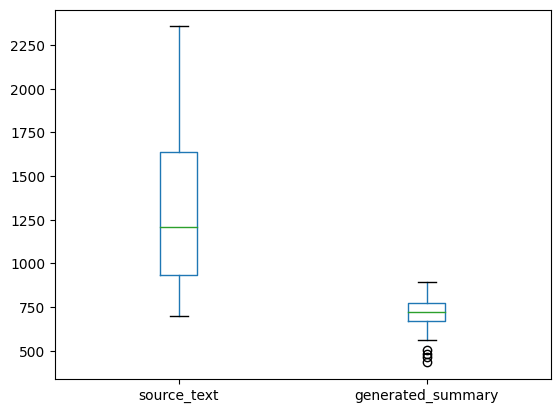

In [ ]:
pd.DataFrame([docs_with_rouge["source_text"].str.len(), docs_with_rouge["generated_summary"].str.len()]).transpose().boxplot(grid=False)

<Axes: >

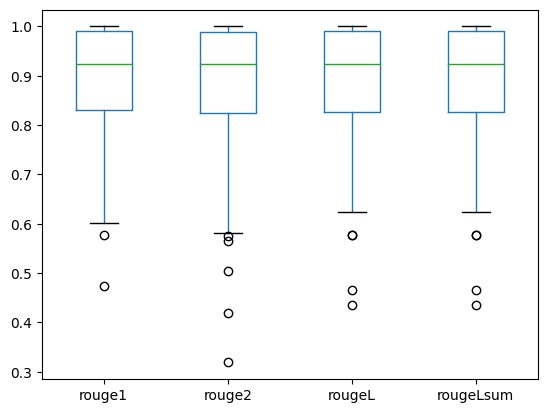

In [ ]:
docs_with_rouge[["rouge1", "rouge2",	"rougeL", "rougeLsum"]].boxplot(grid=False)

In [ ]:
for title, row in docs_with_rouge.head(10).iterrows():
  print(title)
  print(f"Scores: 'rouge1' {row['rouge1']: .2f} | 'rouge2' {row['rouge2']: .2f} | 'rougeL' {row['rougeL']: .2f} | 'rougeLsum' {row['rougeLsum']: .2f}")
  print("###### Original")
  print(textwrap.fill(row["source_text"], 70), "\n\n")
  print("###### Resumo referência")
  print(textwrap.fill(row["target_summary"], 70))
  print("###### Resumo gerado")
  print(textwrap.fill(row["generated_summary"], 70))
  print("\n\n\n")

187-2023-PRE-Ofício Circular
Scores: 'rouge1'  0.90 | 'rouge2'  0.87 | 'rougeL'  0.89 | 'rougeLsum'  0.89
###### Original
Informamos que, a partir de 13/11/2023, inclusive, será alterada a
regra para cadastro automático de vencimentos do Contrato Futuro de
Cupom de IPCA (DAP). A regra de cadastro automático de vencimentos foi
revista, visando ampliar a abertura de novos vencimentos curtos de
DAP, de 3 primeiros meses para 6, conforme tabela abaixo. Regra até
10/11/2023. Regra a partir de 13/11/2023. A regra vigente de cadastro
automático e cadastro pré-aprovado de instrumentos para o DAP pode ser
consultada em Regulação, Estrutura normativa, Regulamentos e manuais,
Negociação, Acessar documentos, Critérios para Criação e Exclusão de
Vencimentos Futuros e Séries de Opções. Ressaltamos que os demais
termos do Contrato Futuro de Cupom de IPCA (DAP) permanecem
inalterados. O único ajuste é referente ao cadastro automático. 


###### Resumo referência
Informamos que, a partir de 13/11/2023,